In [1]:
import jax
import sys

import numpy as np
import matplotlib.pyplot as plt

from utils_eval import train_nn, eval_nn, augment_dataset

sys.path.append("../")
from lib.mmd import target_value_and_grad_riesz
from lib.gd_images import wasserstein_gradient_descent_save
from lib.datasets import get_dataset

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 5-shot Transfer Learning from MNIST to FMNIST

Setting: we have access to 5 samples by class for Fashion MNIST. We flow samples from MNIST towards this reduced dataset to augment it.

In [2]:
## Get dataset
rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng)

n_data_by_class = 200
src_dataset = "MNIST"
tgt_dataset = "FMNIST"
path_data = "~/torch_datasets"

k_shot = 5

master_key, key_src, key_tgt, key_wgd = jax.random.split(master_key, num=4)

X_data_src, y_src, _, _ = get_dataset(key_src, src_dataset, n_data_by_class, path_data)
X_data_tgt, y_tgt, X_test, y_test = get_dataset(key_tgt, tgt_dataset, k_shot, path_data)

In [3]:
## Flow data

lr = 1
n_epochs = 2500 # 30000 # 60000 # 250000 # 10000 # 200000
m = 0.9

target_grad = lambda x, y, key: target_value_and_grad_riesz(x, y, key, n_sample_batch=k_shot)
L_loss, L_xk = wasserstein_gradient_descent_save(X_data_src, X_data_tgt, target_grad, key_wgd,
                                                 lr=lr, m=m, n_epochs=n_epochs, save_interval=n_epochs//10)

Running for 2,500 iterations: 100%|██████████| 2500/2500 [00:17<00:00, 139.10it/s]


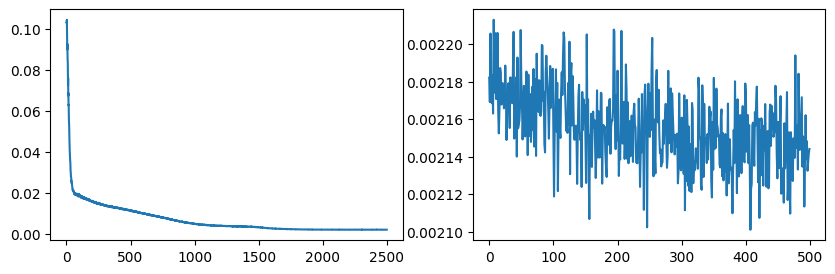

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

ax[0].plot(L_loss)
ax[1].plot(L_loss[-500:])
plt.show()

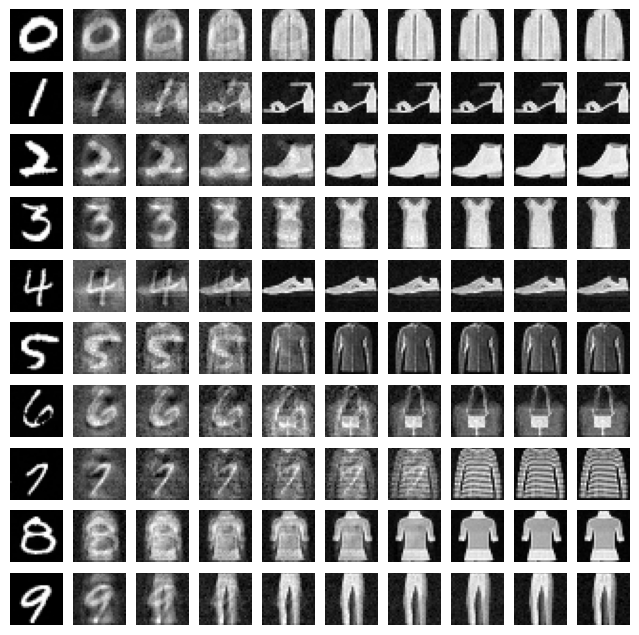

In [5]:
## Flow
n_classes = 10

fig, ax = plt.subplots(n_classes, 10, figsize=(8, 8))

for k in range(n_classes):
    for i in range(10):
        ax[k, i].imshow(L_xk[i][k, 0].reshape(28, 28), "gray")
        ax[k, i].set_axis_off() #("off")

plt.show()

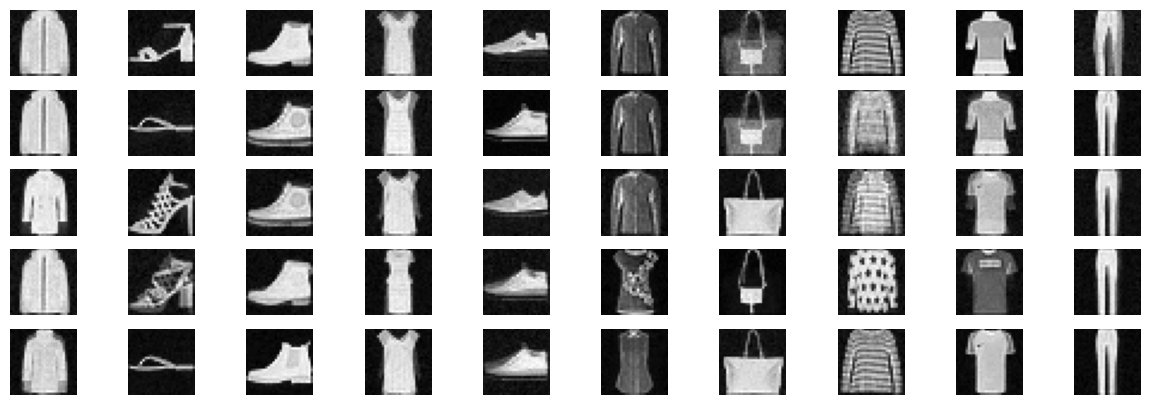

In [6]:
n_classes = 10

# for xk in L_xk:
xk = L_xk[-1]
fig, ax = plt.subplots(5, n_classes, figsize=(15,5))
for k in range(n_classes):
    for i in range(5):
        ax[i, k].imshow(xk[k,i].reshape(28,28), "gray")
        ax[i, k].set_axis_off()
plt.show()

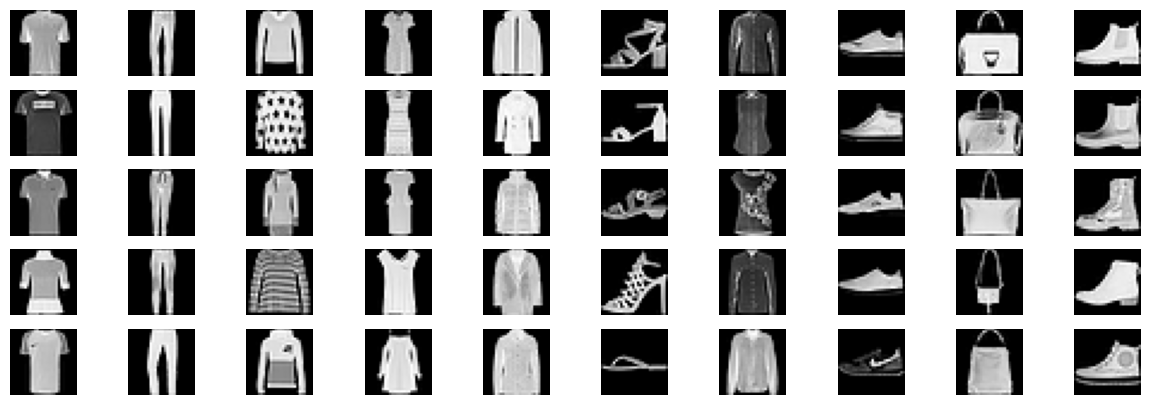

In [7]:
## True data

n_classes = 10

fig, ax = plt.subplots(5, n_classes, figsize=(15,5))
for k in range(n_classes):
    if len(X_data_tgt[k]) > 1:
        for i in range(5):
            ax[i, k].imshow(X_data_tgt[k,i].reshape(28,28), "gray")
            ax[i, k].set_axis_off()
    else:
        ax[0, k].imshow(X_data_tgt[k, 0].reshape(28,28), "gray")
        ax[0, k].set_axis_off()
plt.show()

### Evaluation

In [8]:
def compare_for_epochs(master_key, epochs, X_train, y_train, X_test, y_test, verbose=True):
    res = []
    for e in epochs:
        L = []
        for k in range(5):
            master_key, key = jax.random.split(master_key)
            model = train_nn(key, X_train, y_train, n_epochs=e)
            L.append(eval_nn(model, X_test, y_test))
        mean, std = np.mean(L), np.std(L)
        if verbose:
            print(f"Training for {e} epochs: mean accuracy={mean:.2%}, std={std:.2%}")
        res.append((e,mean,std))
    return res

def compare_target_and_augmented(key, X_tgt, y_tgt, X_aug, y_aug, X_test, y_test, verbose=True):
    n_try = 10
    keys = jax.random.split(key, num=n_try)
    L_baseline, L_aug = [], []

    for key in keys:
        model = train_nn(key, X_tgt, y_tgt, n_epochs=50)
        L_baseline.append(eval_nn(model, X_test, y_test))
        model = train_nn(key, X_aug, y_aug, n_epochs=50)
        L_aug.append(eval_nn(model, X_test, y_test))

    mean1, std1, mean2, std2 = np.mean(L_baseline), np.std(L_baseline), np.mean(L_aug), np.std(L_aug)
    if verbose:
      print(f"Training on available samples: mean accuracy={mean1:.2%}, std={std1:.2%}")
      print(f"Training on true and synthetic samples: mean accuracy={mean2:.2%}, std={std2:.2%}")
    return mean1, std1, mean2, std2

In [9]:
# Train baseline

_ = compare_for_epochs(master_key, range(5, 51, 5), X_data_tgt, y_tgt, X_test, y_test)

100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=2.3002388, acc=0.099999994]


Training for 5 epochs: mean accuracy=10.36%, std=0.63%


100%|██████████| 10/10 [00:00<00:00, 10.76it/s, loss=2.2914155, acc=0.24]      


Training for 10 epochs: mean accuracy=19.98%, std=5.17%


100%|██████████| 15/15 [00:01<00:00, 14.49it/s, loss=2.2801087, acc=0.12]      


Training for 15 epochs: mean accuracy=12.26%, std=2.67%


100%|██████████| 20/20 [00:00<00:00, 20.83it/s, loss=2.2483857, acc=0.34]      


Training for 20 epochs: mean accuracy=23.74%, std=7.66%


100%|██████████| 25/25 [00:01<00:00, 23.87it/s, loss=2.2282574, acc=0.39999998]


Training for 25 epochs: mean accuracy=31.30%, std=7.93%


100%|██████████| 30/30 [00:01<00:00, 29.86it/s, loss=2.187779, acc=0.42]       


Training for 30 epochs: mean accuracy=29.17%, std=3.07%


100%|██████████| 35/35 [00:01<00:00, 33.49it/s, loss=2.2163985, acc=0.35999998]


Training for 35 epochs: mean accuracy=32.55%, std=10.72%


100%|██████████| 40/40 [00:01<00:00, 27.52it/s, loss=2.0543296, acc=0.5]       


Training for 40 epochs: mean accuracy=36.46%, std=3.61%


100%|██████████| 45/45 [00:01<00:00, 41.59it/s, loss=2.0766547, acc=0.42]      


Training for 45 epochs: mean accuracy=36.64%, std=3.41%


100%|██████████| 50/50 [00:01<00:00, 44.20it/s, loss=1.9471071, acc=0.58]      


Training for 50 epochs: mean accuracy=41.58%, std=5.18%


In [10]:
X_aug, y_aug = augment_dataset(L_xk, X_data_tgt, y_tgt, full_path=False, method="rescale")
_ = compare_for_epochs(master_key, range(5, 51, 5), X_aug, y_aug, X_test, y_test)

100%|██████████| 5/5 [00:02<00:00,  1.82it/s, loss=0.94005334, acc=0.76536584]


Training for 5 epochs: mean accuracy=46.16%, std=9.64%


100%|██████████| 10/10 [00:03<00:00,  3.09it/s, loss=0.23115404, acc=0.9434146]


Training for 10 epochs: mean accuracy=56.31%, std=1.93%


100%|██████████| 15/15 [00:03<00:00,  4.44it/s, loss=0.04049851, acc=0.9970732]  


Training for 15 epochs: mean accuracy=56.95%, std=2.19%


100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss=0.0730395, acc=0.9873171]  


Training for 20 epochs: mean accuracy=57.51%, std=1.51%


100%|██████████| 25/25 [00:04<00:00,  5.87it/s, loss=0.016350864, acc=1.0]       


Training for 25 epochs: mean accuracy=58.08%, std=2.32%


100%|██████████| 30/30 [00:04<00:00,  6.37it/s, loss=0.0114238495, acc=1.0]      


Training for 30 epochs: mean accuracy=55.47%, std=2.25%


100%|██████████| 35/35 [00:05<00:00,  6.86it/s, loss=0.009764454, acc=1.0]       


Training for 35 epochs: mean accuracy=55.89%, std=1.16%


100%|██████████| 40/40 [00:05<00:00,  6.85it/s, loss=0.002722858, acc=1.0]       


Training for 40 epochs: mean accuracy=55.84%, std=1.55%


100%|██████████| 45/45 [00:05<00:00,  7.58it/s, loss=0.009472507, acc=1.0]       


Training for 45 epochs: mean accuracy=56.61%, std=2.08%


100%|██████████| 50/50 [00:06<00:00,  7.66it/s, loss=0.009114106, acc=1.0]       


Training for 50 epochs: mean accuracy=56.75%, std=0.56%


In [11]:
X_aug, y_aug = augment_dataset(L_xk, X_data_tgt, y_tgt, full_path=False, method="clip")
_ = compare_for_epochs(master_key, range(5, 51, 5), X_aug, y_aug, X_test, y_test)

100%|██████████| 5/5 [00:02<00:00,  2.01it/s, loss=0.94114316, acc=0.7131707]


Training for 5 epochs: mean accuracy=47.44%, std=8.72%


100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.22995195, acc=0.9385366]


Training for 10 epochs: mean accuracy=56.75%, std=2.16%


100%|██████████| 15/15 [00:03<00:00,  4.57it/s, loss=0.05467414, acc=0.99463415]


Training for 15 epochs: mean accuracy=58.20%, std=1.36%


100%|██████████| 20/20 [00:03<00:00,  5.39it/s, loss=0.058741145, acc=0.99268293]


Training for 20 epochs: mean accuracy=59.09%, std=1.40%


100%|██████████| 25/25 [00:04<00:00,  5.87it/s, loss=0.022571992, acc=0.9995122] 


Training for 25 epochs: mean accuracy=58.17%, std=1.22%


100%|██████████| 30/30 [00:04<00:00,  6.41it/s, loss=0.0097678695, acc=1.0]      


Training for 30 epochs: mean accuracy=56.91%, std=2.36%


100%|██████████| 35/35 [00:05<00:00,  6.76it/s, loss=0.013504249, acc=1.0]       


Training for 35 epochs: mean accuracy=57.80%, std=0.78%


100%|██████████| 40/40 [00:05<00:00,  7.24it/s, loss=0.0025845529, acc=1.0]      


Training for 40 epochs: mean accuracy=56.80%, std=1.11%


100%|██████████| 45/45 [00:05<00:00,  7.63it/s, loss=0.0073054763, acc=1.0]      


Training for 45 epochs: mean accuracy=57.44%, std=1.95%


100%|██████████| 50/50 [00:06<00:00,  7.85it/s, loss=0.010108265, acc=0.9995122] 


Training for 50 epochs: mean accuracy=57.94%, std=0.63%


In [12]:
X_aug, y_aug = augment_dataset(L_xk, X_data_tgt, y_tgt, full_path=True, method="clip")
_ = compare_for_epochs(master_key, range(5, 51, 5), X_aug, y_aug, X_test, y_test)
_ = compare_target_and_augmented(master_key, X_data_tgt, y_tgt, X_aug, y_aug, X_test, y_test)

100%|██████████| 5/5 [00:06<00:00,  1.35s/it, loss=0.14868626, acc=0.9635374] 


Training for 5 epochs: mean accuracy=58.98%, std=0.74%


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, loss=0.05800712, acc=0.985034] 


Training for 10 epochs: mean accuracy=57.49%, std=1.06%


100%|██████████| 15/15 [00:15<00:00,  1.04s/it, loss=0.03798891, acc=0.98947847] 


Training for 15 epochs: mean accuracy=57.68%, std=0.70%


100%|██████████| 20/20 [00:20<00:00,  1.02s/it, loss=0.035191834, acc=0.9902494] 


Training for 20 epochs: mean accuracy=57.18%, std=0.43%


100%|██████████| 25/25 [00:24<00:00,  1.01it/s, loss=0.022781232, acc=0.99337864]


Training for 25 epochs: mean accuracy=57.17%, std=0.71%


100%|██████████| 30/30 [00:28<00:00,  1.04it/s, loss=0.01610456, acc=0.99478453] 


Training for 30 epochs: mean accuracy=57.10%, std=0.79%


100%|██████████| 35/35 [00:33<00:00,  1.03it/s, loss=0.021544686, acc=0.99333334]


Training for 35 epochs: mean accuracy=57.56%, std=0.87%


100%|██████████| 40/40 [00:38<00:00,  1.03it/s, loss=0.0040399856, acc=0.9989569] 


Training for 40 epochs: mean accuracy=57.47%, std=0.86%


100%|██████████| 45/45 [00:42<00:00,  1.05it/s, loss=0.011918639, acc=0.99609977]


Training for 45 epochs: mean accuracy=57.45%, std=1.12%


100%|██████████| 50/50 [00:47<00:00,  1.05it/s, loss=0.009067977, acc=0.9973242] 


Training for 50 epochs: mean accuracy=56.96%, std=0.96%


100%|██████████| 50/50 [00:48<00:00,  1.02it/s, loss=0.006390712, acc=0.99791384] 


Training on available samples: mean accuracy=37.56%, std=9.17%
Training on true and synthetic samples: mean accuracy=57.25%, std=0.58%


In [13]:
X_aug, y_aug = augment_dataset(L_xk, X_data_tgt, y_tgt, full_path=True, method="rescale")
_ = compare_for_epochs(master_key, range(5, 51, 5), X_aug, y_aug, X_test, y_test)
_ = compare_target_and_augmented(master_key, X_data_tgt, y_tgt, X_aug, y_aug, X_test, y_test)

100%|██████████| 5/5 [00:06<00:00,  1.30s/it, loss=0.13837937, acc=0.965805]  


Training for 5 epochs: mean accuracy=58.75%, std=1.14%


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, loss=0.05601366, acc=0.9856689]


Training for 10 epochs: mean accuracy=57.46%, std=1.05%


100%|██████████| 15/15 [00:15<00:00,  1.04s/it, loss=0.04046285, acc=0.98916095]


Training for 15 epochs: mean accuracy=57.92%, std=1.10%


100%|██████████| 20/20 [00:20<00:00,  1.03s/it, loss=0.031721115, acc=0.9912018] 


Training for 20 epochs: mean accuracy=56.73%, std=0.60%


100%|██████████| 25/25 [00:24<00:00,  1.03it/s, loss=0.018585056, acc=0.99410427]


Training for 25 epochs: mean accuracy=57.10%, std=0.82%


100%|██████████| 30/30 [00:29<00:00,  1.03it/s, loss=0.011816252, acc=0.9963265] 


Training for 30 epochs: mean accuracy=56.93%, std=1.00%


100%|██████████| 35/35 [00:34<00:00,  1.02it/s, loss=0.016250638, acc=0.99478453]


Training for 35 epochs: mean accuracy=55.83%, std=0.86%


100%|██████████| 40/40 [00:38<00:00,  1.04it/s, loss=0.0016990594, acc=0.99972785]


Training for 40 epochs: mean accuracy=56.59%, std=1.27%


100%|██████████| 45/45 [00:42<00:00,  1.06it/s, loss=0.012992703, acc=0.9955555] 


Training for 45 epochs: mean accuracy=56.99%, std=0.84%


100%|██████████| 50/50 [00:46<00:00,  1.07it/s, loss=0.007623767, acc=0.99750566]


Training for 50 epochs: mean accuracy=56.22%, std=0.73%


100%|██████████| 50/50 [00:46<00:00,  1.08it/s, loss=0.0032151067, acc=0.9991383] 


Training on available samples: mean accuracy=37.56%, std=9.11%
Training on true and synthetic samples: mean accuracy=55.61%, std=1.37%
